# Inhibitor Diffusion and Germination - Three dimensions

## Numerical experiments - Week 47/2024

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda, float32
import plotly.graph_objects as go

## 1. General assumptions

The spore is now situated in a three-dimensional volume, being able to diffuse in more directions.

The assumptions on permeation through the cell wall and in the medium are as in the previous experiment, but the PDE solutions now extend to three dimensions and all sides of the spore are subject to inhibitor flux.

## 2. Algorithmic framework

### 2.1. Analytical formula

First, a function for obtaining the analytical solution is defined as in the previous experiment.

In [2]:
def permeation_time_dependent_analytical(c_in, c_out, t, Ps, A, V, alpha=1.0):
    """
    Compute the concentration of a solute in a spore given the initial and external concentrations.
    inputs:
        c_in (float) - the initial concentration of the solute;
        c_out (float) - the external concentration of the solute;
        t (float) - time;
        Ps (float) - the spore membrane permeation constant;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore;
        alpha (float) - permeable fraction of the area; defaults to 1.
    """
    tau = V / (alpha * A * Ps)
    c = c_out - (c_out - c_in) * np.exp(-t / tau)
    return c

With it, it can be quickly compared how the number of dimensions affects the concentraiton change

In [3]:
Ps = 1.9e-6
t_max = 14400 # 4 hours
times = np.linspace(0, t_max, 1000)
alpha = 10.0
spore_wall_vol = 125

# 2D setup
spore_area = 20 # 4 sides of square
c_analytical_2D = permeation_time_dependent_analytical(1, 0, times, Ps, spore_area, spore_wall_vol, alpha)

# 3D setup
spore_area = 150
c_analytical_3D = permeation_time_dependent_analytical(1, 0, times, Ps, spore_area, spore_wall_vol, alpha)

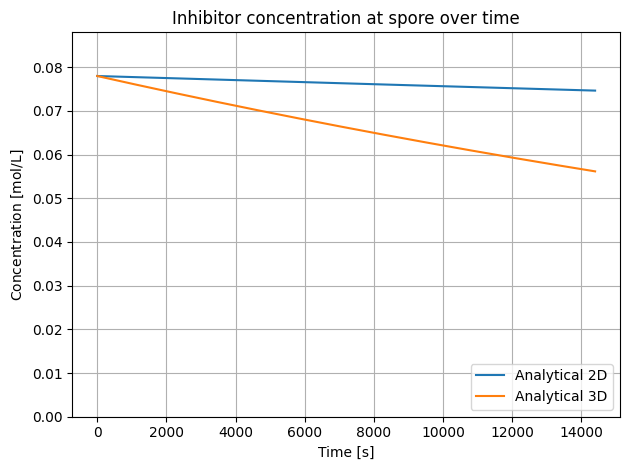

In [ ]:
c_scale = 0.078
c_analytical_2D_scaled = c_scale * c_analytical_2D
c_analytical_3D_scaled = c_scale * c_analytical_3D

# Plot the concentration evolution
fig, ax = plt.subplots()
ax.plot(times, c_analytical_2D_scaled, label='Analytical 2D')
ax.plot(times, c_analytical_3D_scaled, label='Analytical 3D')
ax.set_ylim(0, c_scale+0.01)
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Concentration $[\text{mol}/\text{L}]$')
ax.set_title('Inhibitor concentration at spore over time')
ax.legend(loc='lower right')
ax.grid()
fig.tight_layout()

### 2.2. Numerical algorithm

To test this against finite-size effects, a 3D lattice-based model is constructed, similar to the previous experiments. As the spores will be positioned close to an impermeable bottom surface, the two boundaries in the $z$-dimension are set with a Dirichlet boundary condition of $c(x,y,z,t)=0$.

In [141]:
def invoke_smart_kernel(size, threads_per_block=(8, 8, 8)):
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = [(size + (tpb - 1)) // tpb for tpb in threads_per_block]
    return tuple(blocks_per_grid), tuple(threads_per_block)


@cuda.jit()
def update_GPU_2D(c_old, c_new, dtdx2, D, Dm, spore_idx):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (numpy.ndarray) - the current state of the lattice;
        c_new (numpy.ndarray) - the next state of the lattice;
        dtdx2 (float) - the update factor;
        D (float) - the diffusion constant through the medium;
        Dm (float) - the diffusion constant through the spore membrane;
        spore_idx (tuple) - the indices of the spore location.
    """
    i, j = cuda.grid(2)

    if i >= c_old.shape[0] or j >= c_old.shape[1]:
        return

    center = c_old[i, j]
    bottom = c_old[(i - 1) % c_old.shape[0], j]
    top = c_old[(i + 1) % c_old.shape[0], j]
    left = c_old[i, (j - 1) % c_old.shape[1]]
    right = c_old[i, (j + 1) % c_old.shape[1]]
    
    Ddtdx2 = cuda.local.array(4, float32)
    for k in range(4):
        Ddtdx2[k] = D * dtdx2

    if i == spore_idx[0] and j == spore_idx[1]:
        for k in range(4):
            Ddtdx2[k] = Dm * dtdx2
    elif i == spore_idx[0] - 1 and j == spore_idx[1]:
        Ddtdx2[1] = Dm * dtdx2
    elif i == spore_idx[0] + 1 and j == spore_idx[1]:
        Ddtdx2[0] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] - 1:
        Ddtdx2[3] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] + 1:
        Ddtdx2[2] = Dm * dtdx2
    
    diff_sum = Ddtdx2[0] * bottom + Ddtdx2[1] * top + Ddtdx2[2] * left + Ddtdx2[3] * right
    c_new[i, j] = center + diff_sum - (Ddtdx2[0] + Ddtdx2[1] + Ddtdx2[2] + Ddtdx2[3]) * center



@cuda.jit()
def update_GPU(c_old, c_new, N, dtdx2, D, Dm, spore_idx):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (DeviceNDArray) - the current state of the lattice;
        c_new (DeviceNDArray) - the next state of the lattice;
        dtdx2 (float) - the update factor;
        D (float) - the diffusion constant through the medium;
        Dm (float) - the diffusion constant through the spore membrane;
        spore_idx (tuple) - the indices of the spore location.
    """
    i, j, k = cuda.grid(3)
    # i, j = cuda.grid(2)
    # k = 0

    if i >= c_old.shape[0] or j >= c_old.shape[1] or k >= c_old.shape[2]:
        return
    
    # if k == 0 or k == c_old.shape[2] - 1:
    #     return
    
    # center = c_old[i, j, k]
    # bottom = c_old[(i - 1) % c_old.shape[0], j, k]
    # top = c_old[(i + 1) % c_old.shape[0], j, k]
    # left = c_old[i, (j - 1) % c_old.shape[1], k]
    # right = c_old[i, (j + 1) % c_old.shape[1], k]
    # front = c_old[i, j, (k - 1) % c_old.shape[2]]
    # back = c_old[i, j, (k + 1) % c_old.shape[2]]

    center = c_old[i, j, k]
    bottom = c_old[(i - 1) % N, j, k]
    top = c_old[(i + 1) % N, j, k]
    left = c_old[i, (j - 1) % N, k]
    right = c_old[i, (j + 1) % N, k]
    front = c_old[i, j, (k - 1) % N]
    back = c_old[i, j, (k + 1) % N]

    # ip = (i + 1) % N
    # im = (i - 1 + N) % N
    # jp = (j + 1) % N
    # jm = (j - 1 + N) % N
    # kp = (k + 1) % N
    # km = (k - 1 + N) % N
    
    Ddtdx2a = Dm * dtdx2
    # Ddtdx2 = cuda.local.array(6, np.float32)
    # for k in range(6):
    #     Ddtdx2[k] = D * dtdx2

    Ddtdx20 = D * dtdx2
    Ddtdx21 = D * dtdx2
    Ddtdx22 = D * dtdx2
    Ddtdx23 = D * dtdx2
    Ddtdx24 = D * dtdx2
    Ddtdx25 = D * dtdx2
    
    if i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2]:
        # for k in range(6):
        #     Ddtdx2[k] = Dm * dtdx2
        Ddtdx20 = Dm * dtdx2
        Ddtdx21 = Dm * dtdx2
        Ddtdx22 = Dm * dtdx2
        Ddtdx23 = Dm * dtdx2
        Ddtdx24 = Dm * dtdx2
        Ddtdx25 = Dm * dtdx2
    elif i == spore_idx[0] - 1 and j == spore_idx[1] and k == spore_idx[2]:
        # Ddtdx2[1] = Dm * dtdx2
        Ddtdx21 = Dm * dtdx2
    elif i == spore_idx[0] + 1 and j == spore_idx[1] and k == spore_idx[2]:
        # Ddtdx2[0] = Dm * dtdx2
        Ddtdx20 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] - 1 and k == spore_idx[2]:
        # Ddtdx2[3] = Dm * dtdx2
        Ddtdx23 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] + 1 and k == spore_idx[2]:
        # Ddtdx2[2] = Dm * dtdx2
        Ddtdx22 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2] - 1:
        # Ddtdx2[5] = Dm * dtdx2
        Ddtdx25 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2] + 1:
        # Ddtdx2[4] = Dm * dtdx2
        Ddtdx24 = Dm * dtdx2
        
    
    # diff_sum = Ddtdx2[0] * bottom + Ddtdx2[1] * top + Ddtdx2[2] * left + Ddtdx2[3] * right + Ddtdx2[4] * front + Ddtdx2[5] * back
    # c_new[i, j, k] = center + diff_sum - (Ddtdx2[0] + Ddtdx2[1] + Ddtdx2[2] + Ddtdx2[3] + Ddtdx2[4] + Ddtdx2[5]) * center

    # diff_sum = Ddtdx20 * bottom + Ddtdx21 * top + Ddtdx22 * left + Ddtdx23 * right + Ddtdx24 * front + Ddtdx25 * back
    # diff_sum = Ddtdx20 * (bottom-center) + Ddtdx21 * (top-center) + Ddtdx22 * (left-center) + Ddtdx23 * (right-center) + Ddtdx24 * (front-center) + Ddtdx25 * (back-center)
    # diff_sum = Ddtdx2a * (bottom-center) + Ddtdx2a * (top-center) + Ddtdx2a * (left-center) + Ddtdx2a * (right-center) + Ddtdx2a * (front-center) + Ddtdx2a * (back-center)
    # c_new[i, j, k] = center + diff_sum - (Ddtdx20 + Ddtdx21 + Ddtdx22 + Ddtdx23 + Ddtdx24 + Ddtdx25) * center
    # c_new[i, j, k] = center + diff_sum 

    # diff_sum = Ddtdx2[0] * bottom + Ddtdx2[1] * top + Ddtdx2[2] * left + Ddtdx2[3] * right
    # c_new[i, j, k] = center + diff_sum - (Ddtdx2[0] + Ddtdx2[1] + Ddtdx2[2] + Ddtdx2[3]) * center

    diff_sum = Ddtdx20 * bottom + Ddtdx21 * top + Ddtdx22 * left + Ddtdx23 * right
    c_new[i, j, k] = center + diff_sum - (Ddtdx20 + Ddtdx21 + Ddtdx22 + Ddtdx23) * center

    # c_new[i, j, k] = Ddtdx2a * (bottom + top + left + right + front + back - 6 * center) + center


@cuda.jit
def diffusion_kernel(lattice, new_lattice, D, dt, dx, N):
    # Get the 3D thread indices
    x, y, z = cuda.grid(3)

    if x < N and y < N and z < N:
        # Compute periodic boundary indices
        xp = (x + 1) % N
        xm = (x - 1 + N) % N
        yp = (y + 1) % N
        ym = (y - 1 + N) % N
        zp = (z + 1) % N
        zm = (z - 1 + N) % N

        # Calculate the Laplacian using periodic boundaries
        laplacian = (
            (lattice[xp, y, z] - 2 * lattice[x, y, z] + lattice[xm, y, z]) / (dx * dx) +
            (lattice[x, yp, z] - 2 * lattice[x, y, z] + lattice[x, ym, z]) / (dx * dx) +
            (lattice[x, y, zp] - 2 * lattice[x, y, z] + lattice[x, y, zm]) / (dx * dx)
        )

        # Update the lattice values
        new_lattice[x, y, z] = lattice[x, y, z] + D * dt * laplacian
    

@cuda.reduce
def max_reduce(a, b):
    """
    Find the maximum of two values.
    """
    if a > b:
        return a
    else:
        return b


def diffusion_time_dependent_GPU(c_init, t_max, D=1.0, Dm=1.0, dt=0.001, dx=0.005, n_save_frames=100, spore_idx=(None, None, None), c_thresholds=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        Dm (float) - the diffusion constant through the spore membrane; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        spore_idx (tuple) - the indices of the spore location; defaults to (None, None);
        c_thresholds (float) - threshold values for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 3, 'input array must be 3-dimensional'
    assert c_init.shape[0] == c_init.shape[1] == c_init.shape[2], 'lattice must have equal size along each dimension'
    print(spore_idx)

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    dtdx2 = dt / (dx ** 2)
    print(f"Update factor: {Dm*dtdx2}")

    if  D * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to D, may result in an unstable simulation.")

    if  Dm * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to Dm, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt))
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} microns.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    
    # Array for storing times at which thresholds are reached
    if type(c_thresholds) == np.ndarray:
        times_thresh = np.zeros(c_thresholds.shape)
    else:
        times_thresh = None
    thresh_ct = 0

    # Initialise lattice states
    c_A_gpu = cuda.to_device(c_init)
    c_B_gpu = cuda.to_device(np.zeros_like(c_init))
    # c_grids = [c_A_gpu, c_B_gpu]

    kernel_blocks, kernel_threads = invoke_smart_kernel(N)

    for t in range(n_frames):

        print(f"Frame {t} of {n_frames}", end="\r")

        # Save frame
        if t % save_interval == 0:
            # if t%2 == 0:
            #     c_evolution[save_ct, :, :, :] = c_A_gpu.copy_to_host()
            # else:
            #     c_evolution[save_ct, :, :, :] = c_B_gpu.copy_to_host()
            # c_evolution[save_ct] = c_grids[t%2].copy_to_host()
            c_evolution[save_ct] = c_A_gpu.copy_to_host()
            times[save_ct] = t * dt
            save_ct += 1
        
        # if t%2 == 0:
        #     update_GPU[kernel_blocks, kernel_threads](c_A_gpu, c_B_gpu, dtdx2, D, Dm, spore_idx)
        #     # update_GPU_2D[kernel_blocks, kernel_threads](c_A_gpu, c_B_gpu, dtdx2, D, Dm, spore_idx)
        #     # update_GPU_2D[kernel_blocks, kernel_threads](c_A_gpu[:, :, spore_idx[2]], c_B_gpu[:, :, spore_idx[2]], dtdx2, D, Dm, spore_idx)
        # else:
        #     update_GPU[kernel_blocks, kernel_threads](c_B_gpu, c_A_gpu, dtdx2, D, Dm, spore_idx)
        #     # update_GPU_2D[kernel_blocks, kernel_threads](c_B_gpu, c_A_gpu, dtdx2, D, Dm, spore_idx)
        #     # update_GPU_2D[kernel_blocks, kernel_threads](c_B_gpu[:, :, spore_idx[2]], c_A_gpu[:, :, spore_idx[2]], dtdx2, D, Dm, spore_idx)
        # update_GPU[kernel_blocks, kernel_threads](c_grids[t%2], c_grids[(t+1)%2], dtdx2, D, Dm, spore_idx)
        update_GPU[kernel_blocks, kernel_threads](c_A_gpu, c_B_gpu, N, dtdx2, D, Dm, spore_idx)
        # update_GPU[kernel_blocks, kernel_threads](c_A_gpu, c_B_gpu, N, dtdx2, D, Dm, spore_idx[0], spore_idx[1], spore_idx[2])
        # diffusion_kernel[kernel_blocks, kernel_threads](c_A_gpu, c_B_gpu, D, dt, dx, N)

        # Synchronize the GPU to ensure the kernel has finished
        cuda.synchronize()
        
        c_A_gpu, c_B_gpu = c_B_gpu, c_A_gpu

        print(max_reduce(c_A_gpu.ravel()))

        # Save time if threshold is reached
        if c_thresholds is not None:
            if thresh_ct < times_thresh.shape[0] and times_thresh[thresh_ct] == 0 and max_reduce(c_A_gpu.ravel()) < c_thresholds[thresh_ct]:
                times_thresh[thresh_ct] = t * dt
                thresh_ct += 1

    # Save final frame
    c_evolution[save_ct, :, :, :] = c_A_gpu.copy_to_host()
    times[save_ct] = t_max

    return c_evolution, times, times_thresh

## 3. Experimental setup

Compensated by the extra dimension, the lattice size is reduced to $L=640\mu\text{m}$. This yields a volume of $6.4\times 10^8\mu\text{m}^3=6.4\times 10^{-4}\text{mL}$. The spores are positioned at a distance of $20\mu\text{m}$ from the bottom of the lattice.

In [ ]:
# Initialise lattice with zero concentrations
W = 63
H = 63
L = 63
c_lattice = np.zeros((W+1, H+1, L+1), dtype=np.float32)

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2, L//2)
print(spore_idx)
c_lattice[spore_idx] = c_spore_init

# Run simulation (Dm formulation 2)
c_thresh = c_thresholds = 10.0**(-np.arange(1, 7)) * c_spore_init
D = 600
Dm = 1.9e-5
t_max = 10.5#14400 # 4 hours
c_evolution, times, times_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, Dm=Dm, dt=0.005, dx=5, n_save_frames=100, spore_idx=spore_idx, c_thresholds=c_thresholds)

# Check with analytical solution
Ps = 1.9e-6
# spore_wall_vol = 1.5
spore_wall_vol = 125
# spore_area = 20 # 4 sides of square
# spore_area = 100 # 4 sides of cube
spore_area = 150 # 6 sides of cube
# spore_area = 120.899 # sphere of spore volume
# spore_area = 6.336 # sphere of cell wall volume
# spore_area = 5.241 # 4 sides of cube with cell wall volume
alpha = 10.0
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1], spore_idx[2]]}")
c_analytical = permeation_time_dependent_analytical(c_spore_init, 0, times, Ps, spore_area, spore_wall_vol, alpha)
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical[-1]}")

(31, 31, 31)
(31, 31, 31)
Update factor: 3.8e-09
Simulation running for 12000 steps on a lattice of size [320 320 320] microns.
1.0me 0 of 12000
1.0me 1 of 12000
1.0me 2 of 12000
1.0me 3 of 12000
1.0me 4 of 12000
1.0me 5 of 12000
1.0me 6 of 12000
1.0me 7 of 12000
1.0me 8 of 12000
1.0me 9 of 12000
1.0me 10 of 12000
1.0me 11 of 12000
1.0me 12 of 12000
1.0me 13 of 12000
1.0me 14 of 12000
1.0me 15 of 12000
1.0me 16 of 12000
1.0me 17 of 12000
1.0me 18 of 12000
1.0me 19 of 12000
1.0me 20 of 12000
1.0me 21 of 12000
1.0me 22 of 12000
1.0me 23 of 12000
1.0me 24 of 12000
1.0me 25 of 12000
1.0me 26 of 12000
1.0me 27 of 12000
1.0me 28 of 12000
1.0me 29 of 12000
1.0me 30 of 12000
1.0me 31 of 12000
1.0me 32 of 12000
1.0me 33 of 12000
1.0me 34 of 12000
1.0me 35 of 12000
1.0me 36 of 12000
1.0me 37 of 12000
1.0me 38 of 12000
1.0me 39 of 12000
1.0me 40 of 12000
1.0me 41 of 12000
1.0me 42 of 12000
1.0me 43 of 12000
1.0me 44 of 12000
1.0me 45 of 12000
1.0me 46 of 12000
1.0me 47 of 12000
1.0me 48 of 12000


## 4. Results

Thresholds reached at times: [0. 0. 0. 0. 0. 0.]
Concentration dropped below 1e-06 at time 0.0


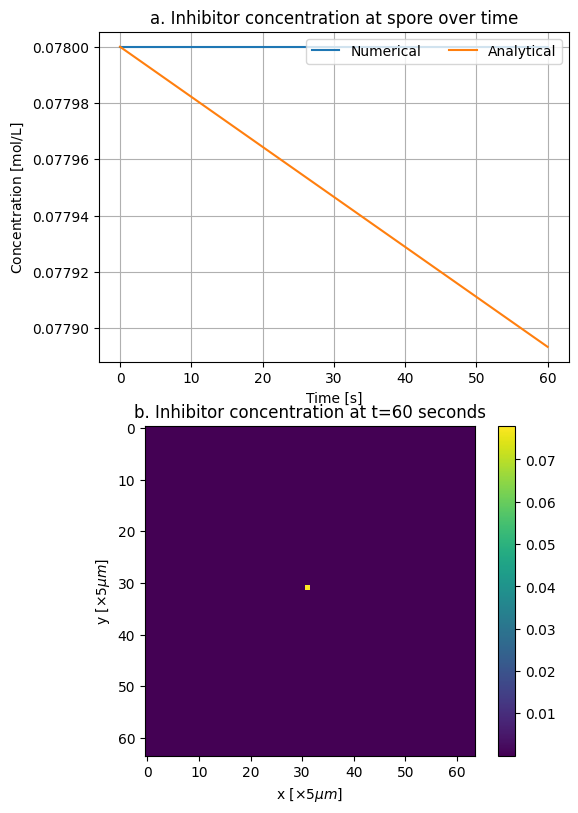

In [144]:
print(f"Thresholds reached at times: {times_thresh}")
print(f"Concentration dropped below {c_thresholds[-1]} at time {times_thresh[-1]}")

c_scale = 0.078
c_analytical_scaled = c_scale * c_analytical
c_evolution_scaled = c_scale * c_evolution

# Compute threshold times analytically
# thresh_times_analytical = time_to_threshold_analytical(c_spore_init, D, spore_vol, 10.0**(-np.arange(1, 7)))

# Plot the concentration evolution
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs[0].plot(times, c_evolution_scaled[:, spore_idx[0], spore_idx[1], spore_idx[2]], label='Numerical')
axs[0].plot(times, c_analytical_scaled, label='Analytical')
for i, time_thresh in enumerate(times_thresh):
    dash_length = (i + 1)
    if time_thresh > 0:
        axs[0].axvline(x=time_thresh, color='c', dashes=(dash_length, dash_length), linewidth=2, label='$k=10^{'+str(-i-1)+'}$')
# for i, time_thresh in enumerate(thresh_times_analytical):
#     dash_length = (i + 1)
#     if time_thresh > 0:
#         axs[0].axvline(x=time_thresh, color='brown', dashes=(dash_length, dash_length), label='$k=10^{'+str(-i-1)+'}$ (analytical)')
# axs[0].set_ylim(0, c_scale+0.01)
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'Concentration $[\text{mol}/\text{L}]$')
axs[0].set_title('a. Inhibitor concentration at spore over time')
axs[0].legend(loc='upper right', ncol=2)
axs[0].grid()
fig.tight_layout()

# Plot final concentrations on lattice
img = axs[1].imshow(c_evolution_scaled[-1, :, :, spore_idx[2]], cmap='viridis')
axs[1].set_xlabel(f'x [$\\times 5\\mu m$]')
axs[1].set_ylabel(f'y [$\\times 5\\mu m$]')
axs[1].set_title(f'b. Inhibitor concentration at t={t_max} seconds')
fig.colorbar(img, ax=axs[1])

In [18]:
# import numpy as np
# from numba import cuda, float32

# Define the CUDA kernel for the diffusion equation
@cuda.jit
def diffusion_kernel(lattice, new_lattice, D, dt, dx, dy, dz, nx, ny, nz):
    # Get the 3D thread indices
    x, y, z = cuda.grid(3)

    if x < nx and y < ny and z < nz:
        # Compute periodic boundary indices
        xp = (x + 1) % nx
        xm = (x - 1 + nx) % nx
        yp = (y + 1) % ny
        ym = (y - 1 + ny) % ny
        zp = (z + 1) % nz
        zm = (z - 1 + nz) % nz

        # Calculate the Laplacian using periodic boundaries
        laplacian = (
            (lattice[xp, y, z] - 2 * lattice[x, y, z] + lattice[xm, y, z]) / (dx * dx) +
            (lattice[x, yp, z] - 2 * lattice[x, y, z] + lattice[x, ym, z]) / (dy * dy) +
            (lattice[x, y, zp] - 2 * lattice[x, y, z] + lattice[x, y, zm]) / (dz * dz)
        )

        # Update the lattice values
        new_lattice[x, y, z] = lattice[x, y, z] + D * dt * laplacian

# Initialize parameters
nx, ny, nz = 64, 64, 64  # Dimensions of the lattice
D = 1.0  # Diffusion coefficient
dt = 0.01  # Time step
dx = dy = dz = 1.0  # Grid spacing
steps = 100  # Number of time steps

# Initialize the lattice with some initial condition
lattice = np.zeros((nx, ny, nz), dtype=np.float32)
lattice[nx // 2, ny // 2, nz // 2] = 100.0  # Point source

# Allocate memory for the new lattice
new_lattice = np.zeros_like(lattice)

# Transfer data to the GPU
d_lattice = cuda.to_device(lattice)
d_new_lattice = cuda.to_device(new_lattice)

# Define the CUDA block and grid sizes
threads_per_block = (8, 8, 8)
grid_dim = (
    (nx + threads_per_block[0] - 1) // threads_per_block[0],
    (ny + threads_per_block[1] - 1) // threads_per_block[1],
    (nz + threads_per_block[2] - 1) // threads_per_block[2]
)

# Perform the time-stepping
for step in range(steps):
    diffusion_kernel[grid_dim, threads_per_block](d_lattice, d_new_lattice, D, dt, dx, dy, dz, nx, ny, nz)
    # Swap the lattices
    d_lattice, d_new_lattice = d_new_lattice, d_lattice

# Copy the result back to the host
lattice = d_lattice.copy_to_host()

# Visualize or process the result
print("Simulation complete. Final state of the lattice:", lattice)
print("Maximum value in the lattice:", np.max(lattice))

Simulation complete. Final state of the lattice: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ...

In [124]:
@cuda.jit
def compute_small_numbers(arr):
    i = cuda.grid(1)
    if i < arr.size:
        arr[i] *= 3.8e-09

# Initialize an array with float32 values
h_array = np.ones(10, dtype=np.float32)

# Copy the array to the device
d_array = cuda.to_device(h_array)

# Define the grid and block dimensions
threads_per_block = 32
blocks_per_grid = (h_array.size + threads_per_block - 1) // threads_per_block

# Launch the kernel
compute_small_numbers[blocks_per_grid, threads_per_block](d_array)

# Copy the result back to the host
h_result = d_array.copy_to_host()

print("Original array:")
print(h_array)
print("\nResult after multiplication:")
print(h_result)

Original array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Result after multiplication:
[3.8e-09 3.8e-09 3.8e-09 3.8e-09 3.8e-09 3.8e-09 3.8e-09 3.8e-09 3.8e-09
 3.8e-09]
